In [30]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_smooth, geom_histogram, stat_function
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Clean Data

In [6]:
# read in data
data = pd.read_csv("spi_matches_latest.csv")

# create new variables
data["spi_diff"] = data.spi1 - data.spi2
data["xg_diff"] = data.xg1 - data.xg2
data["xg_total"] = data.xg1 + data.xg2
data["score_diff"] = data.score1 - data.score2

# drop NA columns (NOTE: some rows are for games that are scheduled but not completed)
data = data.dropna()

## Explore Data

### xG Differential

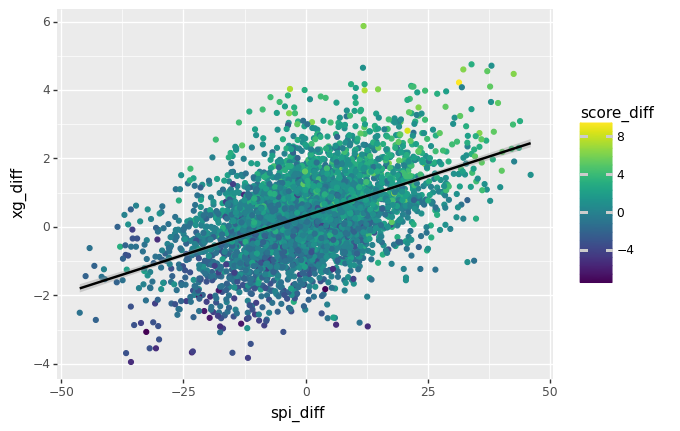

<ggplot: (365466456)>

In [7]:
ggplot(data, aes("spi_diff", "xg_diff")) + geom_point(aes(color="score_diff")) + geom_smooth(method="lm")

A linear model seems appropriate to predict expected goal differential.

### Total xG

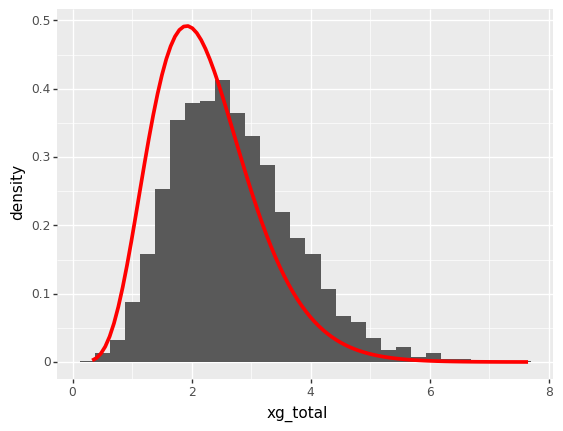

<ggplot: (368816690)>

In [41]:
ggplot(data, aes("xg_total")) + geom_histogram(aes(y="..density.."), bins=30) + stat_function(fun=gamma.pdf, args={"a": 6.75, "scale": 1/2.5}, color="red", size=1.5)

Total expected goals seems to follow a gamma distribution with shape = 6.75 and rate = 2.5. Note that this is approximately equal to shape = mean(xg_total) * 2.5, rate = 2.5.

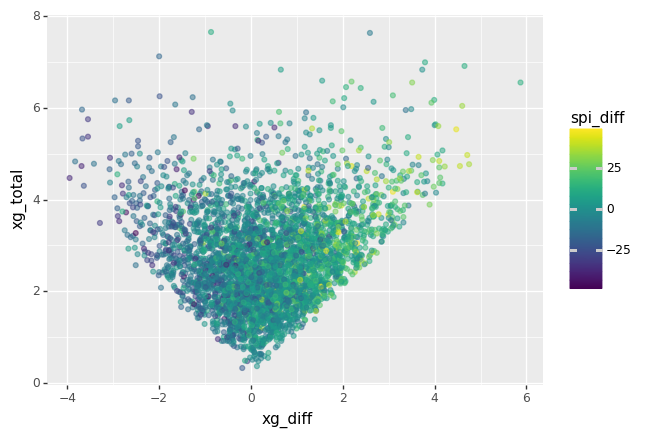

<ggplot: (366049274)>

In [9]:
ggplot(data, aes("xg_diff", "xg_total")) + geom_point(aes(color="spi_diff"), alpha=0.5) 

However, we need to account for expected goal differential because total expected goals is obviously dependent on it.

In [31]:
X = np.array(data.spi_diff).reshape(-1, 1)
y = np.array(data.xg_diff)
model = LinearRegression().fit(X, y)
sigma = mean_squared_error(y, model.predict(X))

In [38]:
n = 4000
samples = pd.DataFrame()
samples["spi_diff"] = np.array(norm.rvs(loc=data.spi_diff.mean(), scale=data.spi_diff.std(), size=n))
samples["xg_diff"] = norm.rvs(loc=model.predict(np.array(samples.spi_diff).reshape(-1, 1)), scale=sigma, size=n)
samples["xg_total"] = gamma.rvs(a=2.35*2.5, scale=1/2.5, size=n) + abs(samples.xg_diff)

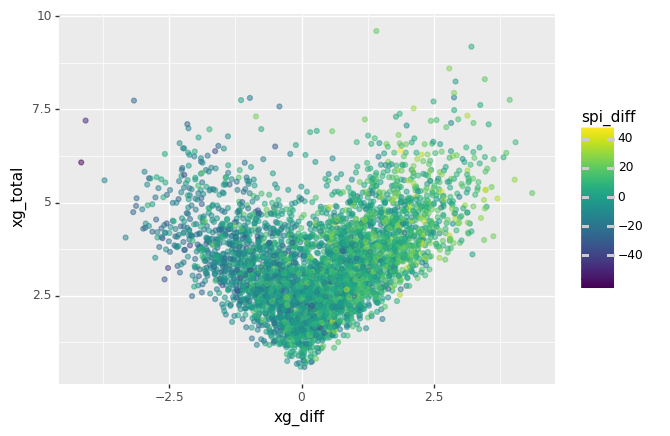

<ggplot: (368668483)>

In [39]:
ggplot(samples, aes("xg_diff", "xg_total")) + geom_point(aes(color="spi_diff"), alpha=0.5) 

To account for the dependency on expected goal differential, I adjust the floor of my output to be the absolute value of the expected goal differential (i.e. the case where one team has zero expected goals). Then, I found the emperical average total goals scored when expected goal differential is close to zero and set that time 2.5 as the shape parameter. To verify this was a reasonable model, I simulated data under this model and compared it to the real data. I think this is good enough, considering expected goal differential is the more important quanity anyway.